In [1]:
import numpy as np
import math
import itertools
from scipy import stats
import matplotlib.pyplot as plt
def rng(m=2**32, a=1103515245, c=12345):
    rng.cu = (a * rng.cu + c) % m
    return rng.cu / m

rng.cu = 2
sample = np.array([rng() for _ in range(1000)])

### Задача 1
Реализовать serial test и применить к выборке samples

In [2]:
def serial_test2d(samp, k):
    xsamp = samp[::2]
    ysamp = samp[1::2]
    obs = np.histogram2d(xsamp, ysamp, bins=k)[0]
    exp = np.full(k * k, samp.size // (2 * k * k))
    print(obs, exp, sep='\n')
    print(stats.chisquare(obs.flatten(), exp))
serial_test2d(sample, 5)

[[27. 23. 20. 15. 23.]
 [14. 17. 14. 24. 28.]
 [22. 20. 21. 14. 31.]
 [23. 19. 14. 21. 18.]
 [17. 17. 23. 18. 17.]]
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20]
Power_divergenceResult(statistic=25.3, pvalue=0.3896078661133287)


### Permutation test

### Задача 2
Реализовать permutation test и применить к выборке samples

In [3]:
def permutation_test(samp, d):
    tmp = samp.reshape((-1,d))
    obs = np.full(math.factorial(d), 0)
    for i in range(tmp.size // d):
        ind = 0
        for perm in itertools.permutations(sorted(tmp[i])):
            if (list(tmp[i]) == list(perm)):
                obs[ind] += 1
                break
            ind += 1
    exp = np.full(math.factorial(d), tmp.size // (d * math.factorial(d)))
    print(obs, exp)
    print(stats.chisquare(obs, exp))
                
permutation_test(sample, 2)
permutation_test(sample[:-40], 4)

[262 238] [250 250]
Power_divergenceResult(statistic=1.152, pvalue=0.28313087066234355)
[ 8  6 12 12 15  9 11 10  5 10 14  5 10  4 11  4 15 16 11 15  8 13  5 11] [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
Power_divergenceResult(statistic=32.0, pvalue=0.1001434048174333)


In [4]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

bad_sample = np.array([rng_bad() for _ in range(30000)])

### Задача 3

Привести статистический тест, который покажет, что с rng_bad есть проблемы, а с rng - нет.

In [5]:
def serial_test3d(samp, n, m, k):
    obs = np.histogramdd(samp.reshape((-1, 3)), bins=(n, m, k))[0]
    exp = np.full(n * m * k, samp.size // (3 * n * m * k))
    #print(obs, exp, sep='\n')
    print(stats.chisquare(obs.flatten(), exp))
sample1 = np.array([rng() for _ in range(30000)])
serial_test3d(sample1, 5, 2, 5)
serial_test3d(bad_sample, 5, 2, 5)

Power_divergenceResult(statistic=54.330000000000005, pvalue=0.27864829992636336)
Power_divergenceResult(statistic=88.62, pvalue=0.00045447033454071474)


## Генерация выборки из заданного распределения

### Задача 4
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса.

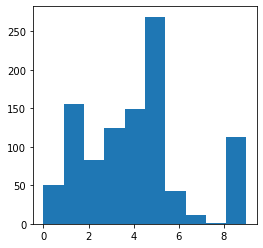

In [6]:
n = 1000
unif = np.random.rand(n)
weight = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
weight = weight / sum(weight)

points = [sum(weight[:i]) for i in range(len(weight) + 1)]
res = []
for dot in unif:
    for j in range(len(weight)):
        if ((dot > points[j]) and (dot < points[j + 1])):
            res.append(j)
            break
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(res, 10)
plt.show()


### Inverse transform method

### Задача 5
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$ с помощью метода Inverse transform. Постройте выборочную гистограмму и точный график плотности распределения.

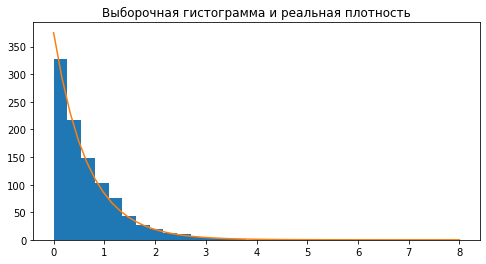

In [7]:
def expon_distrib(param, n):
    r = np.random.rand(n)
    return np.array([(-1 / param) * np.log(1 - x) for x in r])

param = 1.5
n = 1000
expon = expon_distrib(param, n)

fig = plt.subplots(figsize=(8, 4))
plt.hist(expon, 20)
plt.title("Выборочная гистограмма и реальная плотность")
X = np.linspace(0, 8, 50, endpoint=True)

C =  (n // 4) * np.exp(- param* X)
plt.plot(X, param * C)
plt.show()

### Задача 6
Обоснуйте (устно), что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из распределения с плотностью $e^xcos^2x$ на отрезке $[-\pi/2, \pi/2]$. По выборке постройте график выборочной гистограммы и сравните его с графиком точной функции плотности.

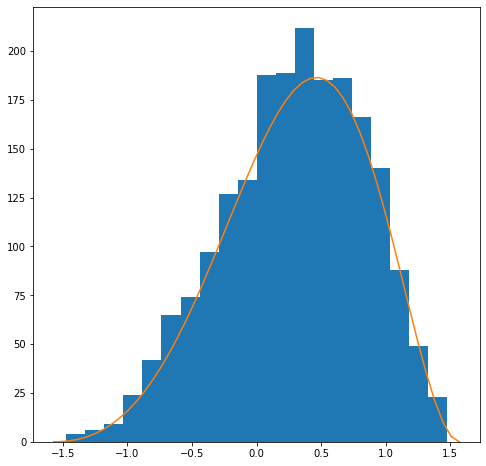

In [8]:
def density(x):
    return 5 / (4 * math.sinh(np.pi / 2)) * (np.exp(x) * (np.cos(x) ** 2))
def standart_density(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-(x)**2 / 2)
def helper(f, g, c, y):
    return f(y) / (c * g(y))

def AR_alg(f, a, b, n):
    c = 76.2308
    res = []
    while(1):
        norm_distr =  np.random.normal(0, 1, n)
        unif_distr = np.random.rand(n)
        for i in range(n):
            if ((norm_distr[i] >= -np.pi/2) and (norm_distr[i] <= np.pi/2)):
                if (helper(f, standart_density, c, norm_distr[i]) > unif_distr[i]):
                    res.append(norm_distr[i])
        if (len(res) >= n):
            return res
    
res = AR_alg(density, -np.pi / 2, np.pi / 2, 2000)
fig = plt.subplots(figsize=(8, 8))
plt.hist(res, 20)

X = np.linspace(-np.pi/2, np.pi/2, 50, endpoint=True)
Y = density(X)
plt.plot(X, 270*Y)

plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей (зачем?).

### Задача 7
Смоделировать и изобразить выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

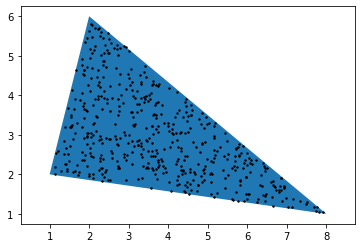

In [67]:
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

samp = np.random.rand(1000).reshape((-1,2))
for i in range(500):
    if samp[i][0] + samp[i][1] > 1:
        samp[i][0] = 1 - samp[i][0]
        samp[i][1] = 1 - samp[i][1]
     
a=np.array([1, 2])
b=np.array([1, 4])
c=np.array([7, -1])

points=[]
for i in range(500):
    points.append(a + samp[i][0] * c + samp[i][1] * b)
points=np.array(points)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

polygon = Polygon(np.array([[1, 2], [2, 6], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.scatter(points[:,0], points[:,1], s=2 ,c='black')
plt.axis('equal')
plt.show()

### Задача 8
Смоделировать без использования метода отбора выборку из 500 точек равномерно распределенных внутри единичного круга. Изобразите полученные точки. Они действительно равномерно заполняют круг?

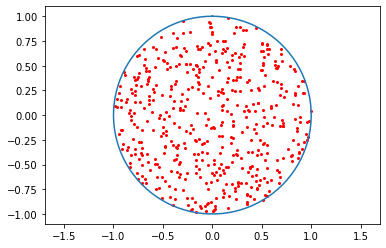

In [73]:
%matplotlib inline
n = 500
angle = np.random.rand(n) * 2 * np.pi
radius = np.sqrt(np.random.rand(n))
res = np.array([np.array([radius[i] * np.cos(angle[i]), radius[i] * np.sin(angle[i])]) for i in range(n)])

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.scatter(res[:,0], res[:,1], s=4, c="red")
plt.show()

## Random normal generator

### Задача 9
Докажите (устно), что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним [4, 7] и ковариационной матрицей [[20,  -4],
       [ -4, 40]]. Постройте 2D гистограмму полученного распределения. Сравните выборочное среднее и ковариационную матрицу с точными значениями.

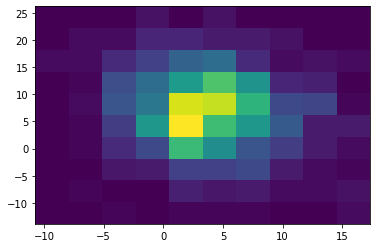

Выборочное среднее [3.84684187 6.86779701]
Выборочная ковариация [[19.11840715 -3.83320845]
 [-3.83320845 40.73413651]]


In [111]:
%matplotlib inline
n=1000
def boxmuller(n):
    l=[]
    i=0
    while i <n:
        x = np.random.rand() * 2 - 1
        y = np.random.rand() * 2 - 1
        s = x**2 + y**2
        if s>0 and s<=1:
            l.append(x*math.sqrt(-2*math.log(s)/s))
            l.append(y*math.sqrt(-2*math.log(s)/s))
            i+=1
    return l


sample=np.array(boxmuller(n)).reshape((-1,2))
a = np.array([20, -4, -4, 40]).reshape((2, 2))
b = np.linalg.cholesky(a)
sample2=np.transpose(np.dot(b, np.transpose(sample)))+np.full((n, 2), [4, 7])
fig = plt.figure()

plt.hist2d(sample2[:,0], sample2[:,1])
plt.show()
print("Выборочное среднее", np.mean(sample2, axis=0))
print("Выборочная ковариация", np.cov(sample2, rowvar=False))